# Example : MPI-Leipzig_Mind-Brain-Body Data

In [40]:
import dfc,FreqDwell,PlotDfc
from dfc import DynamicConnectivityMeasure
from FreqDwell import freq_dwell 
from PlotDFC import plot_dfc
from dfc import upper_tri
import numpy as np
import matplotlib.pyplot as plt


### Loading Parcellated data for 10 subjects over 4 runs for each subject
sub_list=['01','02','04','05','06','07','08','09','11','14']

subjects_ts_AP={}

path= '/Users/majd/Desktop/PhD/Analysis/'

for r in np.arange(1,3):
    subjects_ts_AP['run_%0d'%r]=[]
    for i in sub_list:
        subjects_ts_AP['run_%0d'%r].append(np.load(path+ '/'+
                                   '10subjects' +'/'
                                   'subj_0100%s_ses-02_task-rest_acq-AP_run-0%d_M_BASC_scale064.npz'%(i,r))['ts'])
        
subjects_ts_PA={}
for r in np.arange(1,3):
    subjects_ts_PA['run_%0d'%r]=[]
    for i in sub_list:
        subjects_ts_PA['run_%0d'%r].append(np.load(path+ '/'+
                                   '10subjects' +'/'
                                   'subj_0100%s_ses-02_task-rest_acq-PA_run-0%d_M_BASC_scale064.npz'%(i,r))['ts'])
        

### Computing Dynamic Connectivity states for each run across all subjects

dfc_AP={}
for r in np.arange(1,3):
    dfc_AP['run_0%d'%r]=DynamicConnectivityMeasure(n_states=3,ws=60,ss=1,kinds=['correlation'],
                                    cov_estimator=LedoitWolf(),
                                    saveas='dfc_AP_0%d.npz'%r).fit(np.array(subjects_ts_AP['run_%0d'%r]))
dfc_PA={}
for r in np.arange(1,3):
    dfc_PA['run_0%d'%r]=DynamicConnectivityMeasure(n_states=3,ws=60,ss=1,kinds=['correlation'],
                                    cov_estimator=LedoitWolf(),
                                    saveas='dfc_PA_0%d.npz'%r).fit(np.array(subjects_ts_PA['run_%0d'%r]))
    
### Computing Dwell time and frequency of occurrence of each state in each run 

mods=['correlation']
dwell_AP,freq_AP,grp_dwell_AP,grp_freq_AP={},{},{},{}

for r in np.arange(1,3):
    dwell_AP['run_0%d'%r],freq_AP['run_0%d'%r],grp_dwell_AP['run_0%d'%r],grp_freq_AP['run_0%d'%r]=freq_dwell(dfc_AP['run_0%d'%r].labels,
                                                                                                             n_states=3,mods=mods)
    
dwell_PA,freq_PA,grp_dwell_PA,grp_freq_PA={},{},{},{}
for r in np.arange(1,3):
    dwell_PA['run_0%d'%r],freq_PA['run_0%d'%r],grp_dwell_PA['run_0%d'%r],grp_freq_PA['run_0%d'%r]=freq_dwell(dfc_PA['run_0%d'%r].labels,
                                                                                                             n_states=3,mods=mods) 

### Assessing Cosine Similarity between states in each run and rearranging 

import sklearn
from sklearn.metrics.pairwise import cosine_similarity

data_PA_1=upper_tri(dfc_PA['run_01'].states['correlation'])
data_PA_2=upper_tri(dfc_PA['run_02'].states['correlation'])

data_AP_1=upper_tri(dfc_AP['run_01'].states['correlation'])
data_AP_2=upper_tri(dfc_AP['run_02'].states['correlation'])

simil_PA=cosine_similarity(data_PA_1,data_PA_2)
simil_AP=cosine_similarity(data_AP_1,data_AP_2)
simil_AP_PA=cosine_similarity(data_AP_1,data_PA_1)

order_PA=np.argmax(cosine_similarity(data_PA_1,data_PA_2),axis=1)
order_AP=np.argmax(cosine_similarity(data_AP_1,data_AP_2),axis=1)
order_AP_PA=np.argmax(cosine_similarity(data_AP_1,data_PA_1),axis=1)
dfc_PA['run_02'].states['correlation']=dfc_PA['run_02'].states['correlation'][order_PA]
dfc_AP['run_02'].states['correlation']=dfc_AP['run_02'].states['correlation'][order_AP]
dfc_PA['run_02'].states['correlation']=dfc_PA['run_02'].states['correlation'][order_AP_PA]

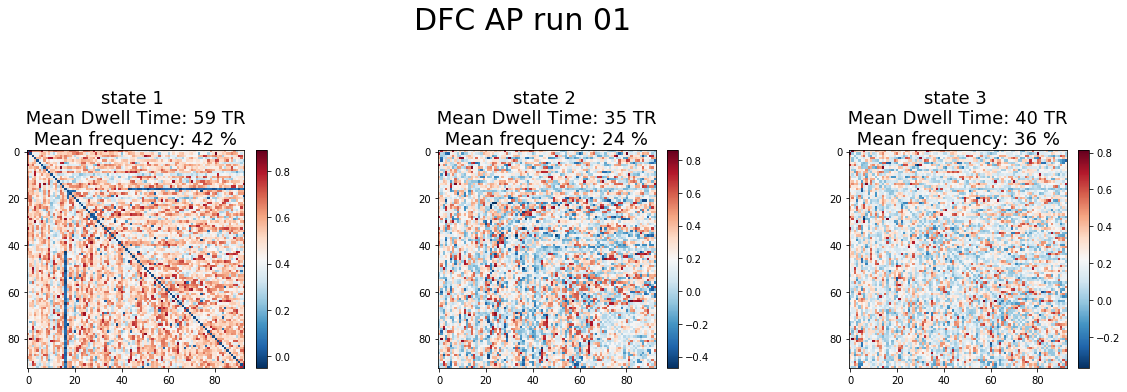

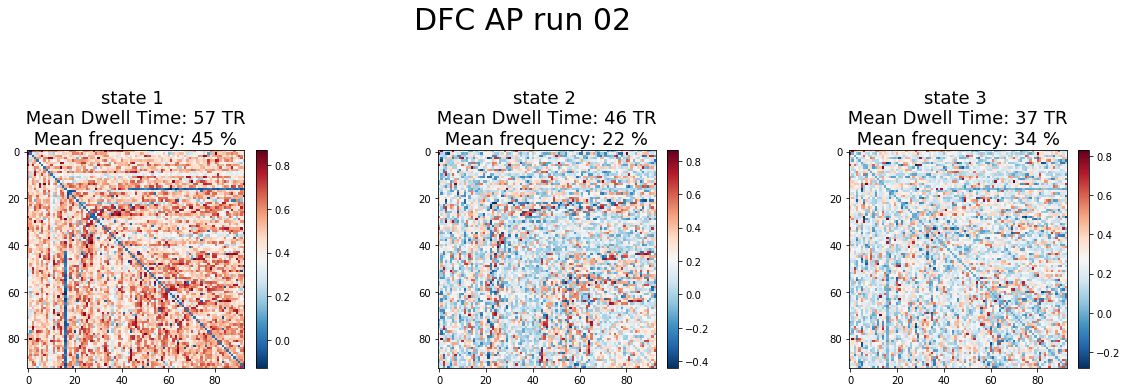

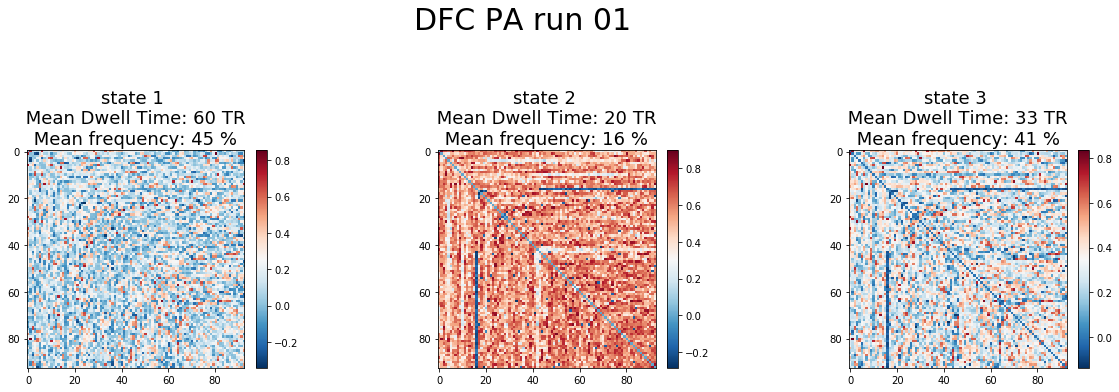

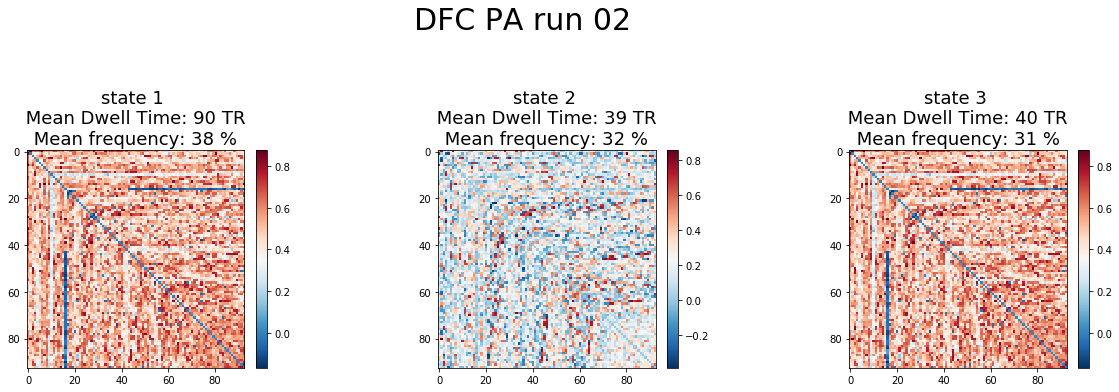

In [44]:
from PlotDFC import plot_dfc
for r in np.arange(1,3):
    plot_dfc(dfc_AP['run_0%d'%r].states,grp_dwell=grp_dwell_AP['run_0%d'%r],
             grp_freq=grp_freq_AP['run_0%d'%r],title='DFC AP run 0%d'%r)
for r in np.arange(1,3):
    plot_dfc(dfc_PA['run_0%d'%r].states,grp_dwell=grp_dwell_PA['run_0%d'%r],
             grp_freq=grp_freq_PA['run_0%d'%r],title='DFC PA run 0%d'%r)